(vqe)=

# Variational Quantum Eigensolver

Автор(ы):

- [Синченко Семен](https://github.com/SemyonSinchenko)


В этой лекции рассмотрим такой классный и очень перспективный алгоритм как `Variational Quantum Eigensolver`. Это алгоритм создан для аппроксимационного решения задачи о собственных значениях матриц. Но, как помним, к этой задаче [можно свести](../../problems2qml/ru/np2ising.md) большое число реально интересных задач, например, _NP_-трудные [задачи комбинаторной оптимизации](../../problems/ru/copt.md). Также к решению проблемы о собственных значениях спиновых систем [сводятся](../../problems2qml/ru/jordanwigner.md) задачи квантовой химии, которые [обсуждались](../../problems/ru/quantchembasic.md) в отдельной лекции.

Задача о собственных значениях, на решение которой направлен рассматриваемый алгоритм [обсуждалась](../../problems2qml/ru/eigenvals.md) ранее, поэтому не будем на ней останавливаться подробно.

## VQE

Теперь давайте посмотрим, как эта задача связана с квантовым компьютером, а также как ее можно свести к градиентному спуску в пространстве параметров `VQE`, содержащей лишь гейты вращения. Напомню, что наличие лишь гейтов вращения [позволяет эффективно считать градиенты](../../grads/ru/gradients.md).

### Собственные значения как результат измерения

Итак, есть эрмитова матрица, для которой хотим найти минимальное собственное значение. То есть сделать примерно то, что делает `ARPACK` или **VMC**, но на квантовом компьютере.

```{note}
Если матрица $A$ не эрмитова, то всегда можно ее дополнить до эрмитовой. Поэтому далее, без потери общности, будем считать эту матрицу именно эрмитовой. Меж тем не будем рассматривать как именно это делать, пока достаточно знать что это возможно.
```

Из первых лекций помним, что любое измерение квантового оператора в каком-то состоянии [есть проекция этого состояния на пространство его собственных векторов](../../qc/ru/qubit.html#id31), а результатом измерения [является одно из его собственных значений](../../qc/ru/qubit.html#id25). При этом распределение вероятностей получения этих собственных значений определяется волновой функцией $\ket{\Psi}$ измеряемого состояния. А значит, то, какое собственное значение получим, будет определяться тем, какое состояние приготовим! Более того, минимальное значение энергии, или минимальное собственное значение в терминах этой задачи является наиболее вероятным результатом измерения основного состояния. Напомним, что результат измерения оператора $\hat{A}$ в состоянии $\ket{\Psi}$ записывается так:

$$
e = \bra{\Psi}\hat{A}\ket{\Psi}
$$

А, как помним из [лекции по параметризованным квантовым схемам](../../vqc/ru/vqc.md), приготовленное состояние задается собственно самой схемой (еще говорят _ansatz_), а также набором ее классических параметров, которые варьируются в процессе обучения.

Так приходим к алгоритму `VQE` -- **V**ariational **Q**uantum **E**igensolver:

1. выбираем _ansatz_ -- параметризованный оператор $\hat{B}(q)$, который представляет из себя последовательность гейтов вращения; вектор $q$ -- это вектор из действительных чисел -- параметров;
2. генерируем случайные начальные параметры $q_0$;
3. цикл обучения, повторяем $n$ раз:
   1. готовим состояние $\ket{\Psi} = \hat{B}(q_n)\ket{0}$;
   2. измеряем $e = \bra{\Psi}\hat{A}\ket{\Psi}$;
   3. вычисляем градиент $g = \frac{\partial{e}}{\partial{q}}$;
   4. обновляем параметры $q_{n+1} = q_n - \alpha g$;
4. результатом обучения являются:
   - набор параметров $q$ такой, что $\hat{B}(q)\ket{0}$ является вектором, близким к первому собственному вектору $\hat{A}$;
   - результат измерения $e$, близкий к первому собственному значению $\hat{A}$.

## Интуиция алгоритма

Если вспомнить подход [**VMC**](../../problems2qml/ru/eigenvals.html#id11) для решения задачи о собственных значениях, то там использовался _trial wave function_ -- некоторое, параметризированное кодирование состояния в его вероятность. С некоторой долей условности можно рассматривать _ansatz_ в **VQE** как квантовый аналог классических _trial wave functions_. Только вместо семплирования при помощи методов Монте-Карло, условно говоря, сэмплируем из реальной волновой функции, когда считаем математическое ожидание результата измерения. Как [помним из первой лекции](../../qc/ru/qubit.html#id31) измерение есть проекция на один из собственных векторов, то есть можно рассматривать это как выбор сэмпла из пространства всех собственных векторов. Причем для определения вероятности используется состояние после применения параметризированного _ansatz_.

## Пример

Решим простую задачку с тривиальной моделью Изинга, который [рассматривали](../../problems/ru/ising.html#numpy) в посвященной этому лекции. Будем использовать тот же код:

In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse import linalg as sl

def sigmaz_k(k: int, n: int) -> (sparse.csr_matrix):
    left_part = sparse.eye(2 ** k)
    right_part = sparse.eye(2 ** (n - 1 - k))

    return sparse.kron(
        sparse.kron(
            left_part,
            sparse.csr_matrix(np.array([[1, 0,], [0, -1,],]))
        ),
        right_part
    )

def ising(j: float, h: float, n: int) -> (sparse.csr_matrix):
    res = sparse.csr_matrix((2 ** n, 2 ** n), dtype=np.complex64)

    for i in range(n - 1):
        res += j * sigmaz_k(i, n) * sigmaz_k(i + 1, n)
        res -= h * sigmaz_k(i, n)

    res -= h * sigmaz_k(n - 1, n)

    return res

Создадим оператор со значениями $j=1.0, h=2.0$:

In [2]:
op = sparse.coo_matrix(ising(j=1.0, h=2.0, n=10))

### Ansatz

Воспользуемся относительно простым вариантом кодирования с использование $CNOT$ и нескольких слоев.

```{note}
Более подробно причина выбора именно такого кодирования, а также подробности внутренней реализации на `PennyLane` рассматривается в практической лекции по **VQE**.
```

In [3]:
import pennylane as qml

N_SPINS = 10
N_LAYERS = 2

device = qml.device("default.qubit", wires=N_SPINS)
ham = qml.SparseHamiltonian(op, wires=list(range(N_SPINS)), id="Hamiltonian")

def layer(params):
    for i in range(N_SPINS):
        qml.RY(params[i][0], wires=i)
        qml.RZ(params[i][1], wires=i)

    for i in range(N_SPINS - 1):
        qml.CZ(wires=[i, i + 1])

@qml.qnode(device, diff_method="parameter-shift")
def feed_forward(params):
    for k in range(N_LAYERS):
        layer(params[k])

    for i in range(N_SPINS):
        qml.RY(params[-1][i][0], wires=i)
        qml.RZ(params[-1][i][1], wires=i)

    return qml.expval(ham)

params = tuple(
    tuple(
        (
            np.random.rand() * 2 * np.pi,
            np.random.rand() * 2 * np.pi,
        )
        for _ in range(N_SPINS)
    )
    for _ in range(N_LAYERS)
)

print(f"Result for random weights: {feed_forward(params):.4f}")

/home/runner/work/qmlcourse/qmlcourse/.venv/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Result for random weights: 0.7413


### Обучение

Возьмем точное решение из [лекции по модели Изинга](../../problems/ru/ising.html#numpy):

In [4]:
exact = -11.0

Запустим обучение и посмотрим, как оно сходится:

/home/runner/work/qmlcourse/qmlcourse/.venv/lib/python3.8/site-packages/pennylane/_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


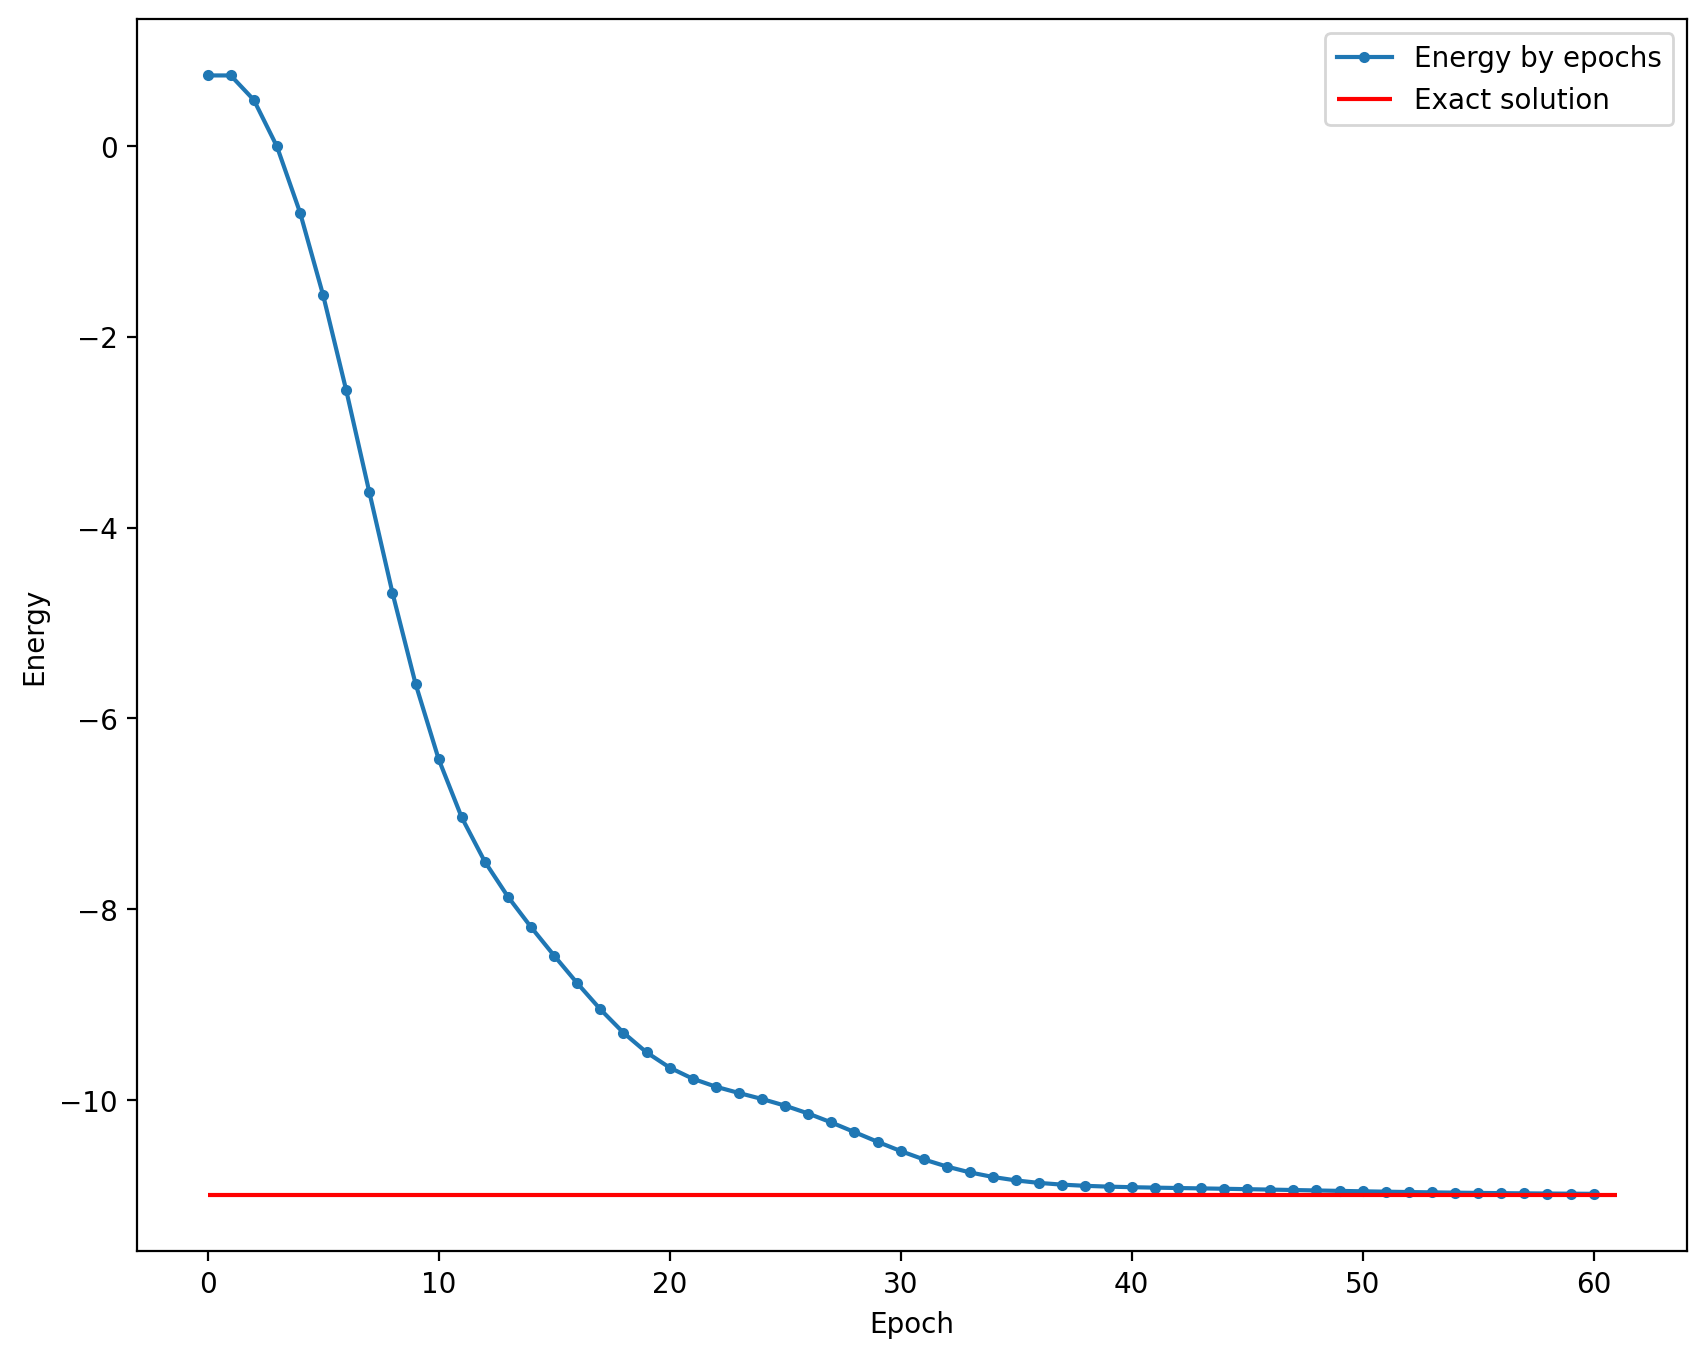

In [5]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

opt = qml.MomentumOptimizer()

energy = [
    feed_forward(params),
]

for epoch in range(60):
    params, e = opt.step_and_cost(feed_forward, params)
    energy.append(e)

plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(energy)), energy, ".-", label="Energy by epochs")
plt.hlines(
    exact,
    0,
    len(energy),
    color="red",
    label="Exact solution",
)
plt.xlabel("Epoch")
plt.ylabel("Energy")
plt.legend()
plt.show()

## Заключение

В этой лекции познакомились в **VQE** -- очень перспективным, красивым и мощным алгоритмом для решения задач о собственных значениях на квантовых компьютерах. В следующей лекции более детально посмотрим на реализацию этого алгоритма в коде, а также обсудим выбранный _ansatz_.